# Tutorial: Download data, value actions and rate players

This tutorial demonstrates how to value on-the-ball actions of football players with the open-source [VAEP framework](https://github.com/ML-KULeuven/socceraction) using the publicly available [Wyscout match event dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000). The Wyscout dataset includes data for the 2017/2018 English Premier League, the 2017/2018 Spanish Primera División, the 2017/2018 German 1. Bundesliga, the 2017/2018 Italian Serie A, the 2017/2018 French Ligue 1, the 2018 FIFA World Cup, and the UEFA Euro 2016. Covering 1,941 matches, 3,251,294 events and 4,299 players, the dataset is large enough to train machine-learning models and obtain robust ratings for the players.

This tutorial demonstrates the following four steps:
1. Download the [Wyscout dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000) and preprocess the relevant data.
2. Value game states by training predictive machine learning models.
  - Compute descriptive features for each game state.
  - Obtain labels for each game state (i.e., *Goal scored within next ten actions? Goal conceded within next ten actions?*)
3. Value on-the-ball actions by using the trained predictive machine learning models.
4. Rate players by aggregating the values of their on-the-ball actions.

**Conventions:**
* Variables that refer a `DataFrame` object are prefixed with `df_`.
* Variables that refer a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

**References:**
* Tom Decroos, Lotte Bransen, Jan Van Haaren, and Jesse Davis. "[Actions Speak Louder than Goals: Valuing Player Actions in Soccer.](https://arxiv.org/abs/1802.07127)" In *Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining*, pp. 1851-1861. 2019.
* Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. "[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions.](https://www.nature.com/articles/s41597-019-0247-7)" *Scientific Data 6*, no. 1 (2019): 1-15.

**Optional:** If you run this notebook on Google Colab, then uncomment the code in the following cell and execute the cell.

In [2]:
# !pip install tables==3.6.1
# !pip install socceraction

**Optional:** If you run this notebook on Google Colab and wish to store all data in a Google Drive folder, then uncomment the code in the following cell and execute the cell.

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %mkdir -p '/content/gdrive/My Drive/Friends of Tracking/'
# %cd '/content/gdrive/My Drive/Friends of Tracking/'

In [6]:
from io import BytesIO

from pathlib import Path

from tqdm.notebook import tqdm

from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve

from zipfile import ZipFile, is_zipfile

In [7]:
import pandas as pd  # version 1.0.3

from sklearn.metrics import brier_score_loss, roc_auc_score  # version 0.22.2
from xgboost import XGBClassifier  # version 1.0.2

import socceraction.classification.features as features
import socceraction.classification.labels as labels

from socceraction.spadl.wyscout import convert_to_spadl
from socceraction.vaep import value

In [8]:
import warnings
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)


In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 

# Download and preprocess the data

This section downloads the Wyscout dataset, collects the required information about the match events, and converts the match events into the SPADL representation.

1. Download the Wyscout dataset;
2. Construct an HDF5 file named `wyscout.h5` that contains the relevant information from the dataset;
3. Convert the `wyscout.h5` file into a `spadl.h5` file that contains the same information in the SPADL representation.

**Note:** The `socceraction` library offers off-the-shelf functionality to convert a collection of Wyscout JSON files into the SPADL representation. However, the JSON files in the publicly available dataset are not directly compatible with the `socceraction` functionality. Therefore, we need to perform a few additional steps to transform the Wyscout data into the SPADL representation.

## Download the Wyscout dataset

The `data_files` `dict` lists the four data files in the Wyscout dataset that are required to run the VAEP framework.
* `events` (73.74 MB): match events for the matches in the dataset;
* `matches` (629.98 kB): overview of the matches in the dataset;
* `players` (1.66 MB): information on the players in the dataset;
* `teams` (26.76 kB): information on the teams in the dataset.

In [10]:
data_files = {
    'events': 'https://ndownloader.figshare.com/files/14464685',  # ZIP file containing one JSON file for each competition
    'matches': 'https://ndownloader.figshare.com/files/14464622',  # ZIP file containing one JSON file for each competition
    'players': 'https://ndownloader.figshare.com/files/15073721',  # JSON file
    'teams': 'https://ndownloader.figshare.com/files/15073697'  # JSON file
}

The following cell loops through the `data_files` `dict`, downloads each listed data file, and stores each downloaded data file to the local file system.

If the downloaded data file is a ZIP archive, the included JSON files are extracted from the ZIP archive and stored to the local file system.

**Note:** If you do not understand what the code below does exactly, then do not worry too much. ;-)

In [11]:
for url in tqdm(data_files.values()):
    url_s3 = urlopen(url).geturl()
    path = Path(urlparse(url_s3).path)
    file_name = path.name
    file_local, _ = urlretrieve(url_s3, file_name)
    if is_zipfile(file_local):
        with ZipFile(file_local) as zip_file:
            zip_file.extractall()

## Preprocess the Wyscout data

The `read_json_file` function reads and returns the content of a given JSON file. The function handles the encoding of special characters (e.g., accents in names of players and teams) that the `pd.read_json` function cannot handle properly.

In [12]:
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

### Teams

The following cells read the `teams.json` file into a `DataFrame` object and store that object in the `wyscout.h5` HDF5 file under the key `teams`.

In [13]:
json_teams = read_json_file('teams.json')
df_teams = pd.read_json(json_teams)

In [14]:
df_teams.head(10)

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
5,Troyes,Troyes,3795,Espérance Sportive Troyes Aube Champagne,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
6,Getafe (Madrid),Getafe,698,Getafe Club de Fútbol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
7,Mönchengladbach,Borussia M'gladbach,2454,Borussia VfL Mönchengladbach,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
8,"Huddersfield, West Yorkshire",Huddersfield Town,1673,Huddersfield Town FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
9,Bilbao,Athletic Club,678,Athletic Club Bilbao,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [15]:
df_teams.to_hdf('wyscout.h5', key='teams', mode='w')

### Players

The following cells read the `players.json` file into a `DataFrame` object and store that object in the `wyscout.h5` HDF5 file under the key `players`.

In [16]:
json_players = read_json_file('players.json')
df_players = pd.read_json(json_players)

In [69]:
df_players.head(10)

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konaté,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,null
5,"{'name': 'Netherlands', 'id': '528', 'alpha3co...",83,Jasper,,Cillessen,676,1989-04-22,185,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Netherlands', 'id': '528', 'alpha3co...",33,right,J. Cillessen,664
6,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",91,Toby,,Alderweireld,1624,1989-03-02,187,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Belgium', 'id': '56', 'alpha3code': ...",36,right,T. Alderweireld,5629
7,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",88,Jan,,Vertonghen,1624,1987-04-24,189,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Belgium', 'id': '56', 'alpha3code': ...",48,left,J. Vertonghen,5629
8,"{'name': 'France', 'id': '250', 'alpha3code': ...",74,Alexander,,Djiku,3783,1994-08-09,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",229427,right,A. Djiku,null
9,"{'name': 'Denmark', 'id': '208', 'alpha3code':...",76,Christian,,Dannemann Eriksen,1624,1992-02-14,180,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Denmark', 'id': '208', 'alpha3code':...",54,right,C. Eriksen,7712


In [17]:
df_players.to_hdf('wyscout.h5', key='players', mode='a')

### Matches

The following cell lists the competitions to be included in the dataset. Uncomment the competitions that you want to include in your dataset.

In [26]:
competitions = [
     #'England',
     #'France',
     #'Germany',
     #'Italy',
     #'Spain',
     'European Championship',
     #'World Cup'
]

The following cells read the `matches.json` files for the selected competitions into a `DataFrame` object and store that object in the `wyscout.h5` HDF5 file under the key `matches`.

In [27]:
dfs_matches = []
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    json_matches = read_json_file(file_matches)
    df_matches = pd.read_json(json_matches)
    dfs_matches.append(df_matches)
df_matches = pd.concat(dfs_matches)

In [28]:
df_matches.head(10)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,groupName,referees,duration,competitionId
0,Played,4165474,0,"{'9905': {'scoreET': 1, 'coachId': 137521, 'si...",9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)",2016-07-10 21:00:00-02:00,Group F,"[{'refereeId': 381617, 'role': 'referee'}, {'r...",ExtraTime,102
1,Played,4165473,0,"{'3148': {'scoreET': 0, 'coachId': 134365, 'si...",9291,2016-07-07 19:00:00,4418,Stade Vélodrome,1694439,"Germany - France, 0 - 2",2016-07-07 21:00:00-02:00,Group F,"[{'refereeId': 377209, 'role': 'referee'}, {'r...",Regular,102
2,Played,4165473,0,"{'10682': {'scoreET': 0, 'coachId': 136439, 's...",9291,2016-07-06 19:00:00,9905,Groupama Stadium,1694438,"Portugal - Wales, 2 - 0",2016-07-06 21:00:00-02:00,Group F,"[{'refereeId': 384373, 'role': 'referee'}, {'r...",Regular,102
3,Played,4165472,0,"{'7839': {'scoreET': 0, 'coachId': 210205, 'si...",9291,2016-07-03 19:00:00,4418,Stade de France,1694437,"France - Iceland, 5 - 2",2016-07-03 21:00:00-02:00,Group F,"[{'refereeId': 377215, 'role': 'referee'}, {'r...",Regular,102
4,Played,4165472,0,"{'3148': {'scoreET': 1, 'coachId': 134365, 'si...",9291,2016-07-02 19:00:00,3148,Stade Matmut-Atlantique,1694436,"Germany - Italy, 1 - 1 (P)",2016-07-02 21:00:00-02:00,Group F,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Penalties,102
5,Played,4165472,0,"{'10682': {'scoreET': 0, 'coachId': 136439, 's...",9291,2016-07-01 19:00:00,10682,Stade Pierre-Mauroy,1694435,"Wales - Belgium, 3 - 1",2016-07-01 21:00:00-02:00,Group F,"[{'refereeId': 384921, 'role': 'referee'}, {'r...",Regular,102
6,Played,4165472,0,"{'9905': {'scoreET': 1, 'coachId': 137521, 'si...",9291,2016-06-30 19:00:00,9905,Stade Vélodrome,1694434,"Poland - Portugal, 1 - 1 (P)",2016-06-30 21:00:00-02:00,Group F,"[{'refereeId': 384898, 'role': 'referee'}, {'r...",Penalties,102
7,Played,4165471,0,"{'7839': {'scoreET': 0, 'coachId': 210205, 'si...",9291,2016-06-27 19:00:00,7839,Allianz Riviera,1694433,"England - Iceland, 1 - 2",2016-06-27 21:00:00-02:00,Group F,"[{'refereeId': 384921, 'role': 'referee'}, {'r...",Regular,102
8,Played,4165471,0,"{'1598': {'scoreET': 0, 'coachId': 134151, 'si...",9291,2016-06-27 16:00:00,3757,Stade de France,1694432,"Italy - Spain, 2 - 0",2016-06-27 18:00:00-02:00,Group F,"[{'refereeId': 384995, 'role': 'referee'}, {'r...",Regular,102
9,Played,4165471,0,"{'10451': {'scoreET': 0, 'coachId': 210902, 's...",9291,2016-06-26 19:00:00,5629,Stadium Municipal,1694431,"Hungary - Belgium, 0 - 4",2016-06-26 21:00:00-02:00,Group F,"[{'refereeId': 384932, 'role': 'referee'}, {'r...",Regular,102


In [29]:
df_matches.to_hdf('wyscout.h5', key='matches', mode='a')

### Events

The following cells read the `events.json` files for the selected competitions into a `DataFrame` object and store that object in the `wyscout.h5` HDF5 file under the key `events/match_<match-id>`.

In [30]:
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_events = f'events_{competition_name}.json'
    json_events = read_json_file(file_events)
    df_events = pd.read_json(json_events)
    df_events_matches = df_events.groupby('matchId', as_index=False)
    for match_id, df_events_match in df_events_matches:
        df_events_match.to_hdf('wyscout.h5', key=f'events/match_{match_id}', mode='a')

## Convert the Wyscout data to the SPADL representation

The following cell calls the `convert_to_spadl` function from the `socceraction` library to convert the `wyscout.h5` HDF5 file into the `spadl.h5` HDF5 file.

In [31]:
convert_to_spadl('wyscout.h5', 'spadl.h5')

  0%|                                                                                         | 0/51 [00:00<?, ?game/s]

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


  0%|                                                                                         | 0/51 [00:00<?, ?game/s]

...Converting events to actions


100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:40<00:00,  1.25game/s]


# Value game states

This section generates features and labels for the game states, trains a predictive machine learning model for each label, and values the game states by applying the trained machine learning models.

1. Generate the features to describe the game states;
2. Generate the labels that capture the value of the game states;
3. Compose a dataset by selecting a set of features and the labels of the game states;
4. Train predictive machine learning models using the dataset;
5. Value the game states using the trained predictive machine learning model.

**Note:** The code in this section is based on the [2-compute-features-and-labels.ipynb](https://github.com/ML-KULeuven/socceraction/blob/master/public-notebooks/2-compute-features-and-labels.ipynb) and [3-estimate-scoring-and-conceding-probabilities.ipynb](https://github.com/ML-KULeuven/socceraction/blob/master/public-notebooks/3-estimate-scoring-and-conceding-probabilities.ipynb) notebooks in the `socceraction` repository.

In [32]:
df_games = pd.read_hdf('spadl.h5', key='games')
df_actiontypes = pd.read_hdf('spadl.h5', key='actiontypes')
df_bodyparts = pd.read_hdf('spadl.h5', key='bodyparts')
df_results = pd.read_hdf('spadl.h5', key='results')

In [33]:
nb_prev_actions = 3

## Generate game state features

The following cell lists a number of *feature generators* from the `features` module in the `socceraction` library. Each function expects either a `DataFrame` object containing actions (i.e., individual actions) or a list of `DataFrame` objects containing consecutive actions (i.e., game states), and returns the corresponding *feature* for the individual action or game state.

In [34]:
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

The following cell generates game states from consecutive actions in each game and computes the features for each game state.

1. Obtain the actions for the game (i.e., `df_actions`) by looping through the games;
2. Construct game states of a given length from the actions (i.e., `dfs_gamestates`);
3. Compute the features for the constructed game states (i.e., `df_features`) by looping through the list of *feature generators*.

In [35]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )
    
    dfs_gamestates = features.gamestates(df_actions, nb_prev_actions=nb_prev_actions)
    dfs_gamestates = features.play_left_to_right(dfs_gamestates, game['home_team_id'])
    
    df_features = pd.concat([function(dfs_gamestates) for function in functions_features], axis=1)
    df_features.to_hdf('features.h5', key=f'game_{game_id}')

## Generate game state labels

The following cell lists a number of *label generators* from the `labels` module in the `socceraction` library. Each function expects either a `DataFrame` object containing actions (i.e., individual actions) or a list of `DataFrame` objects containing consecutive actions (i.e., game states), and returns the corresponding *label* for the individual action or game state.

In [36]:
functions_labels = [
    labels.scores,
    labels.concedes
]

The following cell computes the labels for each action:

1. Obtain the actions for the game (i.e., `df_actions`) by looping through the games;
2. Compute the labels for the actions (i.e., `df_labels`) by looping through the list of *label generators*.

In [37]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )
    
    df_labels = pd.concat([function(df_actions) for function in functions_labels], axis=1)
    df_labels.to_hdf('labels.h5', key=f'game_{game_id}')

## Generate dataset

The following cell generates a list of names for the features to be included in the dataset.

In [38]:
columns_features = features.feature_column_names(functions_features, nb_prev_actions=nb_prev_actions)

The following cell obtains the relevant features for each game and stores them in the `df_features` `DataFrame` object.

In [39]:
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    dfs_features.append(df_features[columns_features])
df_features = pd.concat(dfs_features).reset_index(drop=True)

In [53]:
df_features.head(10)

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,...,end_dist_to_goal_a0,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,80.158369,0.187731,80.158369,0.187731,80.158369,0.187731,True,True,0.000000,0.000000
1,True,False,False,False,False,False,False,False,False,False,...,78.371487,0.354440,80.158369,0.187731,80.158369,0.187731,True,True,2.191167,2.191167
2,True,False,False,False,False,False,False,False,False,False,...,71.690861,0.258985,78.371487,0.354440,80.158369,0.187731,True,True,2.557667,4.748834
3,True,False,False,False,False,False,False,False,False,False,...,85.321753,0.176247,71.690861,0.258985,78.371487,0.354440,True,True,1.044167,3.601834
4,True,False,False,False,False,False,False,False,False,False,...,79.592694,0.357874,85.321753,0.176247,71.690861,0.258985,True,True,3.048458,4.092625
5,False,False,True,False,False,False,False,False,False,False,...,23.519770,0.895657,41.285553,0.741367,25.783747,0.618987,False,False,13.767090,16.815548
6,True,False,False,False,False,False,False,False,False,False,...,31.518001,1.085580,23.519770,0.895657,41.285553,0.741367,True,False,1.193161,14.960251
7,False,False,False,False,False,False,False,False,False,False,...,89.647658,0.388999,94.506002,0.299464,92.147597,0.200588,False,False,3.420165,4.613326
8,False,False,True,False,False,False,False,False,False,False,...,25.144733,1.045928,40.524098,0.995456,31.518001,1.085580,False,True,10.269111,13.689276
9,True,False,False,False,False,False,False,False,False,False,...,36.732596,0.890698,25.144733,1.045928,40.524098,0.995456,True,False,1.401809,11.670920


The following cell lists the names of the labels to be included in the dataset.

In [55]:
columns_labels = [
    'scores',
    'concedes'
]

The following cell obtains the relevant labels for each game and stores them in the `df_labels` `DataFrame` object.

In [42]:
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    dfs_labels.append(df_labels[columns_labels])
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

In [43]:
df_labels.head(10)

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,False
9,False,False


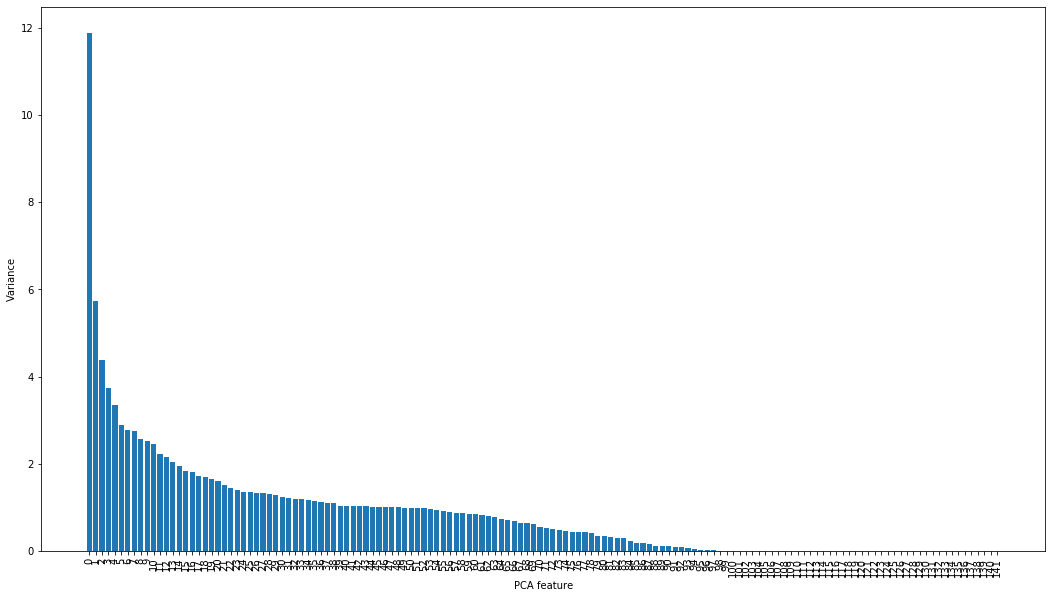

In [85]:
scaler = StandardScaler()
pca = PCA()
from sklearn.pipeline import make_pipeline

pipeline_pca = make_pipeline(scaler, pca)
pca_feat = pipeline_pca.fit_transform(df_features) 


import matplotlib.pyplot as plt


features_pca = range(pca.n_components_)
plt.figure(figsize = (18,10))
plt.bar(features_pca, pca.explained_variance_)
plt.xticks(features_pca, rotation = 90)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.show()

In [87]:
pca = PCA(n_components = 77)
pipeline_pca = make_pipeline(scaler, pca)
pca_feat = pipeline_pca.fit_transform(df_features) 

## Train classifiers

The following cell trains an XGBoost classifier for each label using the computed features. For each label:
1. Construct an XGBoost classifier with default hyperparameters;
2. Train the classifier using the computed features and the label;
3. Store the trained classifier in the `models` `dict`.

In [88]:
%%time
models = {}
for column_labels in columns_labels:
    model = XGBClassifier()
    model.fit(pca_feat, df_labels[column_labels])
    models[column_labels] = model

Wall time: 57.6 s


## Estimate probabilities

The following cell predicts the labels for the game states using the trained XGBoost classifier. For each label:
1. Retrieve the model for the label;
2. Estimate the probabilities of the labels being `False` and `True` given the computed features;
3. Keep the probabilities for the `True` label;
4. Store the probabilities as a `Series` object in the `dfs_predictions` `dict`.

In [111]:
dfs_predictions = {}
for column_labels in columns_labels:
    model = models[column_labels]
    probabilities = model.predict_proba(pca_feat)
    predictions = probabilities[:, 1]
    dfs_predictions[column_labels] = pd.Series(predictions)
df_predictions = pd.concat(dfs_predictions, axis=1)

In [112]:
df_predictions.reset_index(drop = True, inplace = True)
df_predictions.tail(10)

,scores,concedes
62687,0.003373,0.000229
62688,0.000705,0.000100
62689,0.002447,0.000033
62690,0.024767,0.000200
62691,0.000548,0.000069
62692,0.001079,0.000139
62693,0.000291,0.000010
62694,0.006773,0.000008
62695,0.001109,0.000186
62696,0.001630,0.004161


The following cell obtains the `game_id` for each action in order to store the predictions per game.

In [113]:
dfs_game_ids = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    dfs_game_ids.append(df_actions['game_id'])
df_game_ids = pd.concat(dfs_game_ids, axis=0).astype('int').reset_index(drop=True)

The following cell concatenates the `DataFrame` objects with predictions and `game_id`s for each action into a single `DataFrame` object.

In [114]:
df_predictions = pd.concat([df_predictions, df_game_ids], axis=1)

In [115]:
df_predictions.head(10)

,scores,concedes,game_id
0,0.001135,0.000028,1694440
1,0.000128,0.000031,1694440
2,0.000414,0.000010,1694440
3,0.000354,0.000111,1694440
4,0.000466,0.000045,1694440
5,0.000681,0.000007,1694440
6,0.001596,0.000350,1694440
7,0.001886,0.000532,1694440
8,0.001556,0.001342,1694440
9,0.005188,0.000310,1694440


The following cell groups the predictions per game based on their `game_id`.

In [116]:
df_predictions_per_game = df_predictions.groupby('game_id')

The following cell stores the predictions in the `predictions.h5` HDF5 file per game.

In [117]:
for game_id, df_predictions in tqdm(df_predictions_per_game):
    df_predictions = df_predictions.reset_index(drop=True)
    df_predictions[columns_labels].to_hdf('predictions.h5', key=f'game_{game_id}')

# Value on-the-ball actions

**Note:** The code in this section is based on the [4-compute-vaep-values.ipynb](https://github.com/ML-KULeuven/socceraction/blob/master/public-notebooks/4-compute-vaep-values.ipynb) notebook in the `socceraction` repository.

In [118]:
df_players = pd.read_hdf('spadl.h5', key='players')
df_teams = pd.read_hdf('spadl.h5', key='teams')

In [119]:
dfs_values = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .merge(df_players, how='left')
        .merge(df_teams, how='left')
        .reset_index(drop=True)
    )
    
    df_predictions = pd.read_hdf('predictions.h5', key=f'game_{game_id}')
    df_values = value(df_actions, df_predictions['scores'], df_predictions['concedes'])
    
    df_all = pd.concat([df_actions, df_predictions, df_values], axis=1)
    dfs_values.append(df_all)

In [120]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [121]:
df_values[
    ['short_name', 'scores', 'concedes', 'offensive_value', 'defensive_value', 'vaep_value']
].head(10)

,short_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,O. Giroud,0.001900,0.000259,0.000000,-0.000000,0.000000
1,A. Griezmann,0.000496,0.000076,-0.001404,0.000184,-0.001221
2,N. Kanté,0.000753,0.000281,0.000257,-0.000206,0.000051
3,L. Koscielny,0.000040,0.000867,-0.000713,-0.000586,-0.001299
4,P. Evra,0.000747,0.000741,0.000747,-0.000741,0.000006
5,C. Săpunaru,0.000146,0.001256,-0.000595,-0.000509,-0.001104
6,C. Săpunaru,0.000130,0.001524,-0.000016,-0.000268,-0.000284
7,B. Matuidi,0.000097,0.000077,-0.001427,0.000053,-0.001374
8,C. Tătărușanu,0.001011,0.001304,0.000934,-0.001208,-0.000273
9,C. Tătărușanu,0.003359,0.000140,0.002348,0.001164,0.003512


# Rate players

**Note:** The code in this section is based on the [5-top-players.ipynb](https://github.com/ML-KULeuven/socceraction/blob/master/public-notebooks/5-top-players.ipynb) notebook in the `socceraction` repository.

## Rate according to total VAEP value

In [122]:
df_ranking = (df_values[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'))
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

In [123]:
df_ranking.head(10)

,player_id,team_name,short_name,vaep_count,vaep_sum
0,77521.0,Iceland,A. Gunnarsson,270,3.785408
1,8278.0,Wales,G. Bale,347,3.462409
2,7870.0,Wales,A. Ramsey,347,3.168070
3,70134.0,Portugal,Rui Patrício,252,2.784342
4,76201.0,Hungary,Á. Lang,243,2.605360
5,25714.0,France,D. Payet,438,2.602474
6,14723.0,Germany,T. Kroos,751,2.505215
7,49855.0,Switzerland,Y. Sommer,143,2.337965
8,3682.0,France,A. Griezmann,347,2.281069
9,70965.0,Portugal,João Mário,403,2.250934


## Rate according to total VAEP value per 90 minutes

In [124]:
df_player_games = pd.read_hdf('spadl.h5', 'player_games')
df_player_games = df_player_games[df_player_games['game_id'].isin(df_games['game_id'])]

In [125]:
df_minutes_played = (df_player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [126]:
df_minutes_played.head(10)

,player_id,minutes_played
0,36,463.289773
1,48,370.397027
2,66,405.000000
3,93,455.940612
4,97,280.211195
5,122,169.188484
6,151,149.133144
7,354,111.073973
8,3269,362.523550
9,3276,374.521601


In [127]:
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90 = df_ranking_p90[df_ranking_p90['minutes_played'] > 360]
df_ranking_p90['vaep_rating'] = df_ranking_p90['vaep_sum'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90 = df_ranking_p90.sort_values('vaep_rating', ascending=False)

In [128]:
df_ranking_p90.head(10)

,player_id,team_name,short_name,vaep_count,vaep_sum,minutes_played,vaep_rating
0,77521.0,Iceland,A. Gunnarsson,270,3.785408,439.585454,0.775018
4,76201.0,Hungary,Á. Lang,243,2.605360,374.853293,0.625531
2,7870.0,Wales,A. Ramsey,347,3.168070,457.505431,0.623220
1,8278.0,Wales,G. Bale,347,3.462409,551.009829,0.565538
7,49855.0,Switzerland,Y. Sommer,143,2.337965,372.445552,0.564960
5,25714.0,France,D. Payet,438,2.602474,516.544493,0.453441
10,14771.0,Croatia,V. Ćorluka,273,1.946038,409.631802,0.427563
6,14723.0,Germany,T. Kroos,751,2.505215,559.043131,0.403313
3,70134.0,Portugal,Rui Patrício,252,2.784342,653.390335,0.383524
8,3682.0,France,A. Griezmann,347,2.281069,538.531925,0.381214


In [129]:
df_ranking_p90.to_csv('rankingEuroPCA.csv', index=False)